In [5]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
from PIL import Image
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [6]:
# Path to images
image_path = 'C:/Users/djcoo/NeuralNet_Project/Images/'

# Path to test dataset
test_path = 'C:/Users/djcoo/NeuralNet_Project/Images/data_test.csv'

# Path to train dataset 
train_path = 'C:/Users/djcoo/NeuralNet_Project/Images/data_train.csv'

In [7]:
# Get a transfer dataset 
device = torch.device('cpu')
net = tv.models.resnet18(pretrained=True)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Load in the data
# loading dataset
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(train)
print('\n')
print(test)

     Unnamed: 0                    path  class_id  minifigure_name_x  \
0           295     marvel/0001/002.jpg         1         SPIDER-MAN   
1           300     marvel/0001/003.jpg         1         SPIDER-MAN   
2           299     marvel/0001/009.jpg         1         SPIDER-MAN   
3           298     marvel/0001/010.jpg         1         SPIDER-MAN   
4           297     marvel/0001/005.jpg         1         SPIDER-MAN   
..          ...                     ...       ...                ...   
335         182  star-wars/0015/007.jpg        36  EMPEROR PALPATINE   
336         180            test/071.jpg        36  EMPEROR PALPATINE   
337         179  star-wars/0015/005.jpg        36  EMPEROR PALPATINE   
338         184  star-wars/0015/006.jpg        36  EMPEROR PALPATINE   
339         181            test/073.jpg        36  EMPEROR PALPATINE   

                   tmp_name  minifigure_name_y  
0            1 - SPIDER-MAN         SPIDER-MAN  
1            1 - SPIDER-MAN         S

In [9]:
#Convert the csv into a torch dataset
class LEGODataSet(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, img_size, transform=None):
        self.df = pd.read_csv(csv_file)[['path','class_id']]
        #Dropping unnecessary columns
        self.root_dir = root_dir
        #Added Image Size
        self.img_size = img_size
        self.transform = transform


    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        path = image_path + row['path']
        img = io.imread(path)
        img = skimage.transform.resize(img, self.img_size, anti_aliasing=True)
        #Added y to dict to showcase output labels
        #We're doing class_id - 1 because we want the output to be from 0 to N
        y = torch.tensor(row['class_id']-1, dtype=torch.long)
        
        if self.transform:
            img = self.transform(img)
        
        sample = {'image': img, 'id_min_1': y}
        #Returns as dict
        return sample

# Normalize, rescale, and "tensorizing"   
norm_transform = tv.transforms.Compose([
                                tv.transforms.ToTensor(),
                                #VERSATILE MEAN/STD FROM IMAGENET
                                tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])
                                      ])    
    
#CHANGE ACCORDINGLY (ROOTDIR)
torch_lego_train = LEGODataSet(csv_file = train_path, 
                               root_dir = image_path,
                               img_size = (256,256),
                               transform = norm_transform
                              )
torch_lego_test = LEGODataSet(csv_file = test_path, 
                              root_dir = image_path,
                              img_size = (256,256),
                              transform = norm_transform
                             )

dataloader_train = torch.utils.data.DataLoader(torch_lego_train, batch_size = 4, shuffle = True)
dataloader_test = torch.utils.data.DataLoader(torch_lego_test, batch_size = 4, shuffle = True)

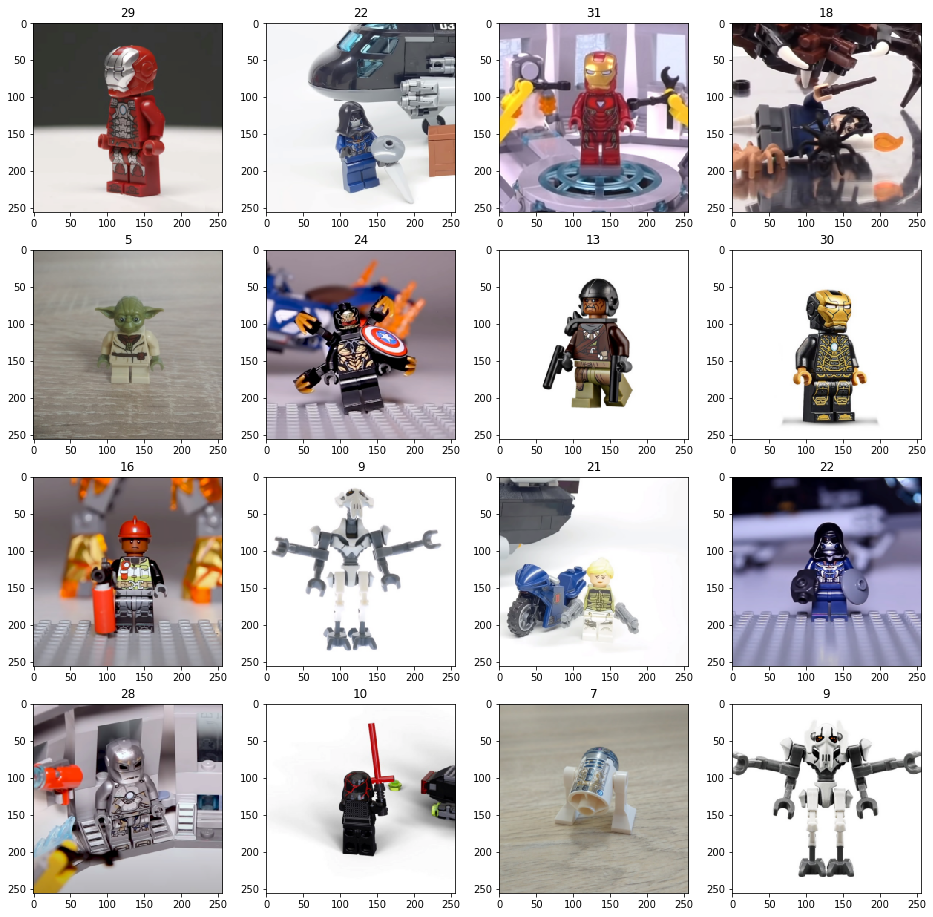

In [10]:
#For loop to normalize all train
fig = plt.figure(figsize=(16, 16))
#Iterate through the torch dataset with dataloader and enumerate
for i, batch in enumerate(dataloader_train):
    #Plus one over here to properly match the class_ids
    images, ids = batch['image'], batch['id_min_1']+1
    for j in range(len(images)):
        plt.subplot(4, 4, 4 * i + j + 1)
        norm_view_img = np.array(images[j]).transpose(1,2,0)
        #Just reversing normalization process in below line
        reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
        plt.imshow(reg_view_img)
        plt.title(ids[j].numpy())
    if i==3:
        break

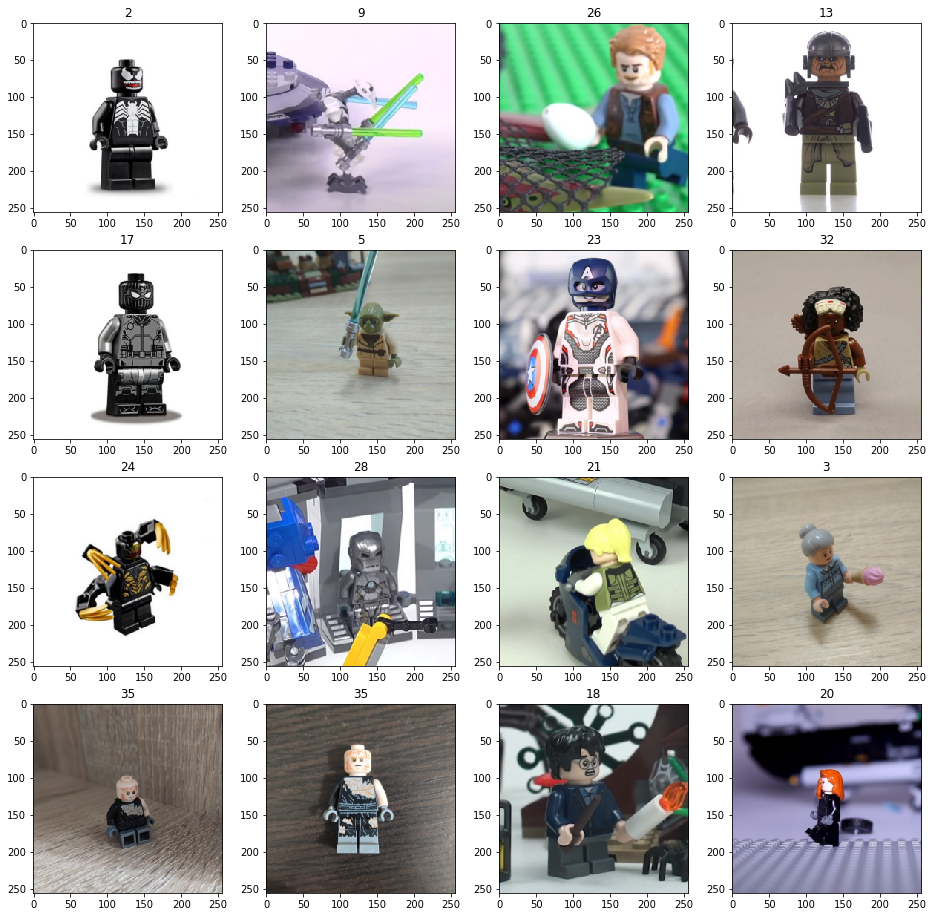

In [11]:
#For loop to normalize all test
fig = plt.figure(figsize=(16, 16))
#Iterate through the torch dataset with dataloader and enumerate
for i, batch in enumerate(dataloader_test):
    #Plus one over here to properly match the class_ids
    images, ids = batch['image'], batch['id_min_1']+1
    for j in range(len(images)):
        plt.subplot(4, 4, 4 * i + j + 1)
        norm_view_img = np.array(images[j]).transpose(1,2,0)
        #Just reversing normalization process in below line
        reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
        plt.imshow(reg_view_img)
        plt.title(ids[j].numpy())
    if i==3:
        break

# Implement Neural Network 

In [35]:
# Hyperparameters for our Neural Network  
n_epochs = 5           # Number of runs through the model. We divide the data up into  
n_classifiers = 36     # Number of classes that we want to predict for 
momentum = 0.9         # Momentum for optimizer 
learning_rate = .001   # Learning rate for our model 

# User stuff
print_every = 5        # How often do we want to print our performance?  

In [36]:
# Define your loss function, optimizer and features 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# Define the accuracy of the model 
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

# Define the number of INPUT features in your model 
num_ftrs = net.fc.in_features

# Set the number of OUTPUT features/categories your model is classifying 
net.fc = nn.Linear(num_ftrs, n_classifiers)

In [37]:
# Initialize list to store loss and accuracy data while training the data
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
target_stuff = []

# Iterate through every training epoch 
total_step = len(dataloader_train)
for epoch in range(1, n_epochs+1):
    
    # Initialze loss variables 
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    
    # Iterate through every training batch
    for batch_idx, batch in enumerate(dataloader_train):
        
        #Plus one over here to properly match the class_ids
        data_, target_ = batch['image'].to(device), batch['id_min_1'].to(device)
        data_ = data_.float()
        
        optimizer.zero_grad()
        outputs = net(data_)
        
        # Compute the loss of the forward pass 
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        
        # Calculate the number of correct predictions vs. the total number of predictions
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        
        # Print out the epoch number, batch index, total number of steps and loss
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
            
    # Append the perfromance information to the lists to plot later
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    
    # Print out the training loss
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    
    # Record the batch loss, the number of correct 
    batch_loss = 0
    total_t = 0
    correct_t = 0
    
    # Turn requires_grad off into all of the block below. 
    # This is common practice in validation because it makes sure you have not leaked any training
    # data in your testing data AND that 
    with torch.no_grad():
        net.eval()
        
        for batch in dataloader_test:
            # Plus one over here to properly match the class_ids
            data_t, target_t = batch['image'].to(device), batch['id_min_1'].to(device)
            data_t = data_t.float()
            outputs_t = net(data_t)
            
            # Compute the loss of the 
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            
            # Pick the max probability prediction 
            _,pred_t = torch.max(outputs_t, dim=1)
            
            # Count the number of correct predictions in a batch 
            correct_t += torch.sum(pred_t==target_t).item()
            
            # Total number of predictions in a batch
            total_t += target_t.size(0)
            
        # Append the percent correct number of predictions to the accuracy list
        val_acc.append(100 * correct_t/total_t)
        
        # Append the loss value to the loss vector 
        val_loss.append(batch_loss/len(dataloader_test))
        
        # Did we improve our performance from the previous batch 
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        # Save the output of the neural network to a file when the network has improved its performance
        if network_learned:
            # Update our minimum loss if and only if the performance improved from the prior batch
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
            
    # Train the network 
    net.train()

Epoch 1

Epoch [1/5], Step [0/85], Loss: 3.2883
Epoch [1/5], Step [5/85], Loss: 4.2132
Epoch [1/5], Step [10/85], Loss: 3.8081
Epoch [1/5], Step [15/85], Loss: 4.1822
Epoch [1/5], Step [20/85], Loss: 3.7887
Epoch [1/5], Step [25/85], Loss: 4.2053
Epoch [1/5], Step [30/85], Loss: 3.2298
Epoch [1/5], Step [35/85], Loss: 3.1403
Epoch [1/5], Step [40/85], Loss: 3.6622
Epoch [1/5], Step [45/85], Loss: 3.5448
Epoch [1/5], Step [50/85], Loss: 3.8276
Epoch [1/5], Step [55/85], Loss: 3.2628
Epoch [1/5], Step [60/85], Loss: 3.1977
Epoch [1/5], Step [65/85], Loss: 3.1693
Epoch [1/5], Step [70/85], Loss: 3.0215
Epoch [1/5], Step [75/85], Loss: 3.2675
Epoch [1/5], Step [80/85], Loss: 3.2928

train-loss: 3.4867, train-acc: 7.0588
validation loss: 2.6977, validation acc: 25.8824

Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/85], Loss: 2.8457
Epoch [2/5], Step [5/85], Loss: 2.3363
Epoch [2/5], Step [10/85], Loss: 3.2702
Epoch [2/5], Step [15/85], Loss: 2.3537
Epoch [2/5], Step [20/85

In [38]:
# Show what the output should look like 
n_classes = 36
batch_size = 4

loss = nn.CrossEntropyLoss()
input_ = torch.randn(batch_size, n_classes, requires_grad = True)
target = torch.empty(batch_size, dtype=torch.long).random_(n_classes)
output = loss(input_, target)
print(input_)
print(target)
print(output)

tensor([[ 0.0397,  0.8776,  0.0184, -0.1743,  0.5331, -0.5890,  1.7847, -0.3808,
          0.6482,  0.5763, -0.0418, -0.3026, -0.2424, -0.8969,  0.8847,  0.2326,
          0.2719, -1.7735,  1.4073,  0.2759,  0.1935, -1.6272,  1.1932,  0.7318,
         -0.2741, -0.6220,  0.5104,  0.9447, -0.0435, -0.3405, -0.6156, -0.5881,
         -1.2381, -0.2777, -1.8761,  0.8750],
        [ 0.7997, -0.5347,  0.6545, -1.2049,  0.6010,  0.1372,  0.7697,  0.5290,
          0.2575, -0.6910, -1.0477,  1.5697, -1.2193, -0.1702, -0.0606,  0.5292,
         -0.4364, -0.4546,  0.6895,  1.1452, -1.7412, -0.2099, -1.0611,  0.1813,
          1.3573,  0.5667,  1.0210,  0.3481, -1.3298, -0.9769,  1.4272, -1.6691,
          1.3832,  0.0417, -1.1617,  1.1304],
        [-1.4332,  0.2147, -1.8533, -1.1471, -0.1738,  0.3653,  1.0047,  0.8940,
         -0.6113,  0.2200, -1.0700,  0.2924, -0.1781, -0.2553, -0.2473, -0.0279,
         -0.9736, -0.8241, -1.4830,  0.1699, -1.1190, -1.2297,  0.2748,  1.0269,
          0.2058,

In [39]:
next(iter(dataloader_train))

{'image': tensor([[[[ 0.6734,  0.6734,  0.6734,  ...,  0.5878,  0.5792,  0.5792],
           [ 0.6734,  0.6734,  0.6734,  ...,  0.5707,  0.5707,  0.5707],
           [ 0.6734,  0.6734,  0.6734,  ...,  0.5707,  0.5707,  0.5707],
           ...,
           [ 1.3113,  1.3499,  1.3627,  ...,  1.2557,  1.3070,  1.3456],
           [ 1.3413,  1.3713,  1.3841,  ...,  1.2642,  1.3156,  1.3413],
           [ 1.3584,  1.3755,  1.3927,  ...,  1.2642,  1.3156,  1.3456]],
 
          [[ 0.8179,  0.8179,  0.8179,  ...,  0.6254,  0.6166,  0.6166],
           [ 0.8179,  0.8179,  0.8179,  ...,  0.6078,  0.6078,  0.6078],
           [ 0.8179,  0.8179,  0.8179,  ...,  0.6078,  0.6078,  0.6078],
           ...,
           [ 1.5226,  1.5620,  1.5751,  ...,  1.4263,  1.4744,  1.5007],
           [ 1.5532,  1.5751,  1.5882,  ...,  1.4394,  1.4832,  1.5138],
           [ 1.5707,  1.5882,  1.5926,  ...,  1.4482,  1.4919,  1.5226]],
 
          [[ 1.0365,  1.0365,  1.0365,  ...,  0.8448,  0.8361,  0.8361],
    

In [40]:
i = 0
for batch in dataloader_test:
    if i==0:
        data_t, target_t = batch['image'].to(device), batch['id_min_1'].to(device)
        data_t = data_.float()
        print(data_t)
        break
print()
outputs_t = net(data_t)
print(outputs_t)

tensor([[[[-0.3541, -0.3541, -0.3669,  ..., -0.2342, -0.2342, -0.2342],
          [-0.3797, -0.3840, -0.3969,  ..., -0.2342, -0.2342, -0.2342],
          [-0.4054, -0.4054, -0.4140,  ..., -0.2342, -0.2342, -0.2342],
          ...,
          [ 0.3866,  0.4037, -0.0158,  ..., -0.1314, -0.2984, -0.5553],
          [-0.2770, -0.3712, -0.6109,  ..., -0.1785, -0.2856, -0.5724],
          [-0.4097, -0.4568, -0.7608,  ..., -0.2256, -0.3198, -0.6238]],

         [[-0.2325, -0.2325, -0.2325,  ..., -0.0924, -0.0924, -0.0924],
          [-0.2325, -0.2325, -0.2325,  ..., -0.0924, -0.0924, -0.0924],
          [-0.2325, -0.2325, -0.2325,  ..., -0.0924, -0.0924, -0.0924],
          ...,
          [ 1.7808,  1.9165,  1.5839,  ...,  1.3825,  1.3037,  1.0674],
          [ 1.1943,  1.2862,  1.2819,  ...,  1.3169,  1.2731,  1.0324],
          [ 1.1900,  1.4438,  1.5007,  ...,  1.2731,  1.2556,  0.9799]],

         [[ 0.0082,  0.0082,  0.0082,  ...,  0.1651,  0.1651,  0.1651],
          [ 0.0082,  0.0082,  

In [41]:
# Iterate through every training batch
i = 0 
for batch_idx, batch in enumerate(dataloader_test):
    if i ==0: 
        #Plus one over here to properly match the class_ids
        data_, target_ = batch['image'].to(device), batch['id_min_1'].to(device)
        data_ = data_.float()
        outputs = net(data_)
        print(outputs)
        break

tensor([[ 2.9766e-01, -7.7923e-01, -6.6723e-01, -8.1797e-01,  6.3720e-01,
         -6.4532e-01,  8.2673e-01,  6.4301e-01,  9.4601e-01,  4.0546e-01,
         -5.5301e-01, -4.6132e-01, -7.3600e-02, -2.6872e-03,  4.1439e-01,
          5.9383e-01,  5.5176e-02,  1.0208e-01,  6.9984e-02, -1.0561e+00,
          1.3460e-01, -7.7908e-01, -1.8653e-01, -5.1371e-01,  3.8205e-01,
         -3.8234e-01, -9.2123e-01,  1.0513e+00,  4.2216e-01, -5.6062e-01,
         -2.2066e-01, -1.2346e-01,  1.2019e+00, -1.9525e-01, -1.8214e+00,
          2.1193e-01],
        [-1.2532e-01,  7.2020e-01,  7.6996e-01, -8.5132e-01,  5.8833e-01,
         -8.7223e-01,  3.5548e-01,  5.3639e-01, -7.5315e-02,  4.9947e-01,
         -7.3625e-02,  6.1200e-01,  6.3888e-01, -5.4146e-01, -5.9332e-01,
          7.2277e-01, -1.2159e-01,  5.2530e-01, -1.0803e+00, -1.3004e+00,
          2.4527e-01,  4.5580e-03,  3.4879e-01, -3.1120e-01, -1.0685e-02,
         -9.2655e-01,  1.9299e+00,  7.3788e-01, -2.4077e-03, -9.9092e-01,
         -7.813

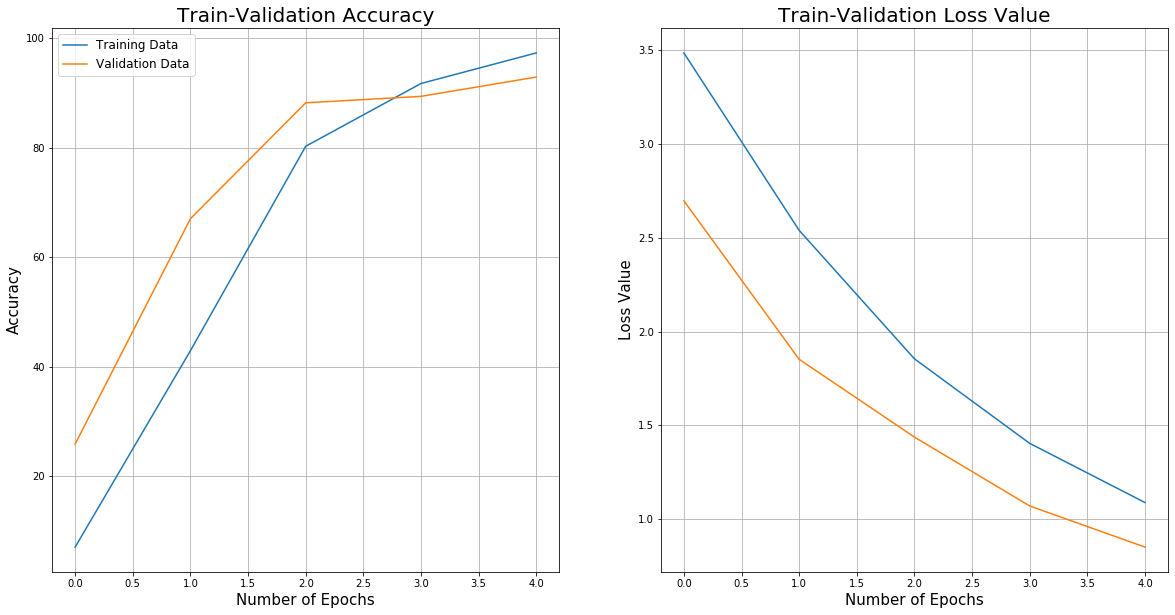

In [56]:
# Train-Validation Accuracy
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title("Train-Validation Accuracy", fontsize=20)
plt.plot(train_acc, label='Training Data')
plt.plot(val_acc, label='Validation Data')
plt.xlabel('Number of Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(loc='best', fontsize=12)
plt.grid()

# Train-Validation Loss Value
plt.subplot(1, 2, 2)
plt.title("Train-Validation Loss Value", fontsize=20)
plt.plot(train_loss, label='Training Data')
plt.plot(val_loss, label='Validation Data')
plt.xlabel('Number of Epochs', fontsize=15)
plt.ylabel('Loss Value', fontsize=15)
plt.grid();
plt.save

AttributeError: 'LEGODataSet' object has no attribute 'id_min_1'

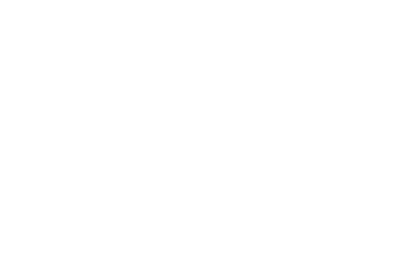

In [33]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(dataloader_test):
        inputs, labels = data['image'], data['id_min_1']
        inputs = inputs.float()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predicts: {}'.format(torch_lego_test.id_min_1[preds[j]]))
            norm_view_img = np.array(inputs[j]).transpose(1,2,0)
            #Just reversing normalization process in below line
            reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
            plt.imshow(reg_view_img)
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()